In [38]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML
from surprise.model_selection.split import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV, cross_validate

%matplotlib inline

In [39]:
user_ratings_df = pd.read_csv("./Data/user_reviews_no_zero.csv", index_col=[0])

In [40]:
user_ratings_df.head()

,user_id,recipe_id,date,rating,review
10,56680,79222,2006-11-11,5.0,"Oh, This was wonderful! Had a soup and salad ..."
11,183565,79222,2006-02-13,5.0,Wow! My family loves this recipe and it is a ...
12,101823,79222,2006-03-21,5.0,Excellent chowder. This was the perfect warm-...
13,446143,79222,2008-02-01,4.0,"Oh, how wonderful! I doubled the crab, and ad..."
14,226989,79222,2008-03-07,4.0,DH and I enjoyed this. However I used it only ...


In [42]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 10 to 598157
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    537267 non-null  int64  
 1   recipe_id  537267 non-null  int64  
 2   date       537267 non-null  object 
 3   rating     537267 non-null  float64
 4   review     537267 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 24.6+ MB


In [43]:
#df[['one', 'two', 'three']] = df[['one', 'two', 'three']]. astype(str) #
user_ratings_df[["user_id", "recipe_id"]] = user_ratings_df[["user_id", "recipe_id"]].astype(str)
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 10 to 598157
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    537267 non-null  object 
 1   recipe_id  537267 non-null  object 
 2   date       537267 non-null  object 
 3   rating     537267 non-null  float64
 4   review     537267 non-null  object 
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


## Modeling Setup 

In [44]:
# Set up data frame for Surprise using user_id, recipe_id, and rating
rating_surprise_df = user_ratings_df[["user_id", "recipe_id", "rating"]]
len(rating_surprise_df["recipe_id"].value_counts())

40526

In [45]:
rating_surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 10 to 598157
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    537267 non-null  object 
 1   recipe_id  537267 non-null  object 
 2   rating     537267 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.4+ MB


In [46]:
len(rating_surprise_df["user_id"].value_counts())

17096

In [47]:
reader = Reader(rating_scale=(1,5))
surprise_data = Dataset.load_from_df(rating_surprise_df, reader)

In [48]:
surprise_data

In [49]:
#Set up train_test_split 
trainset, testset = surprise_train_test_split(surprise_data, test_size= 0.2, random_state=42)

## Dummy Model

In [50]:
#Instantiate the NormalPredictor() from Surprise
baseline = NormalPredictor()

#Fit on the trainset
baseline.fit(trainset)

#Predict ratings on testset
predictions = baseline.test(testset)

#Scoring based on RMSE
baseline = accuracy.rmse(predictions)

RMSE: 0.7609


Our Dummy Model has a Root Mean Squared Error (RMSE) of 0.76 meaning that our dummy model predicts ratings that are on average 0.76 points off of the "true" ratings of recipes. This is pretty decent but let's see if other models can drive down that score. 

## Baseline Only Model

In [51]:
# Instantiate BaselineOnly() from Surprise
baseline_only = BaselineOnly()

# Fit on the trainset
baseline_only.fit(trainset)

# Predict ratings on the testset
predictions = baseline_only.test(testset)

# Scoring based on RMSE
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.5602


The Baseline Only model has an RMSE of 0.56 meaning that our baseline only model predicts ratings that are on average 0.56 points off of the "true" ratings of the recipes. This is an improvement over our Dummy Model but can be improved upon using more complicated models. 

## SVD Model

In [52]:
# Instantiate SVD Model with default hyperparameters
svd = SVD(random_state=42)

# Fit on the trainset
svd.fit(trainset)

# Predict ratings on the testset
predictions = svd.test(testset)

# Scoring based on RMSE
SVD_default = accuracy.rmse(predictions)

RMSE: 0.5654


The SVD Model with default hyperparameters has an RMSE of 0.57 meaning that our model predicts ratings that are on average 0.57 points off of the true ratings of the recipes. While this is slightly worse performing than our Baseline Only model, we can adjust hyperparameters to see if it performs better. We will perform a gridsearch to see the best performing RMSE. 

## Gridsearch with SVD Model

In [37]:
# Set parameters for the gridsearch
SVD_param = {'n_factors':[50,100,150],
             #'n_epochs':[10,20,30],
            #'lr_all': [.0025, .005, .01]}

#Set up the Gridsearch using the parameters above
#svd_gridsearch = GridSearchCV(SVD, param_grid = SVD_param, measures = ["rmse", "mae"], cv=5)

# Fit the gridsearch on the full dataset as the gridsearch will perform splits internally
#svd_gridsearch.fit(surprise_data)

# Pull out best_params from the gridsearch based on RMSE
svd_gridsearch.best_params["rmse"]


{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.0025}

In [39]:
# Instantiate SVD with best_params 
svd_gs_best_params = SVD(n_factors = 50, n_epochs=30, lr_all = .0025, random_state=42)

In [41]:
# Fit best params on the trainset
svd_gs_best_params.fit(trainset)

# Predict ratings on the test set
predictions = svd_gs_best_params.test(testset)

# Scoring based on RMSE
svd_gs_best_params_model = accuracy.rmse(predictions)

RMSE: 0.5627


The SVD Model with best parameters from the gridsearch has. an RMSE of 0.5627 meaning that our model predicts ratings that are on average 0.563 points off of the true ratings of the recipes. This is slightly worse performing than our Baseline Only model. However, we noticed the n_epochs were on the higher end of our bound and our n_factors were at the lower bound, so we can attempt the gridsearch again adjusting these two parameters. 

In [44]:
# New parameter dictionary
SVD_params_2 = {'n_factors':[10,25,50],
             'n_epochs':[30, 40, 50],
            'lr_all': [.0025]}

# Set up the Gridsearch using the parameters above
#svd_gridsearch_2 = GridSearchCV(SVD, param_grid = SVD_params_2, measures = ["rmse", "mae"], cv=5)

# Fit on the full data 
#svd_gridsearch_2.fit(surprise_data)

# Pull out best_params from the gridsearch based on RMSE
#svd_gridsearch_2.best_params["rmse"]

{'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.0025}

In [45]:
# Instantiate SVD with new best_params 
svd_gs_best_params_model2 = SVD(n_factors = 10 ,  n_epochs= 30  , lr_all = .0025, random_state=42)

# Fit model on the trainset data
svd_gs_best_params_model2.fit(trainset)


# Predict ratings on the testset
predictions = svd_gs_best_params_model2.test(testset)

# Scoring based on RMSE
svd_gs_model_2 = accuracy.rmse(predictions)

RMSE: 0.5600


The SVD Model with best parameters from the gridsearch has. an RMSE of 0.560 meaning that our model predicts ratings that are on average 0.56 points off of the true ratings of the recipes. This is the best performing model so far. We could drop the n_factors since again it is at the lower bounds of the settings, but the difference in RMSE may be minimal with the computation power tradeoff.

In [21]:
# Gridsearch using lower n_factors
SVD_params_3 = {'n_factors':[3,5,10],
             'n_epochs':[25, 30, 35],
            'lr_all': [.0025]}

# Set up the Gridsearch using the parameters above
#svd_gridsearch_3 = GridSearchCV(SVD, param_grid = SVD_params_3, measures = ["rmse", "mae"], cv=5)

# Fit on the full data
#svd_gridsearch_3.fit(surprise_data)

# Pull out best_params from the gridsearch based on RMSE
#svd_gridsearch_3.best_params["rmse"]

{'n_factors': 3, 'n_epochs': 35, 'lr_all': 0.0025}

In [22]:
#Instantiate on SVD model
svd_model_3 = SVD(n_factors = 3 ,  n_epochs= 35  , lr_all = .0025, random_state=42)

#Fit on trainset
svd_model_3.fit(trainset)

# Predict for testset
predictions = svd_model_3.test(testset)

#RMSE 
svd_model_3 = accuracy.rmse(predictions)

RMSE: 0.5593


The SVD Model with best parameters from the gridsearch has. an RMSE of 0.559 meaning that our model predicts ratings that are on average 0.56 points off of the true ratings of the recipes. This is the best performing model so far, but only slightly beter than our last SVD model. We could drop the n_factors since again it is at the lower bounds of the settings, but the difference in RMSE may be minimal with the computation power tradeoff. 

## Gridsearch with SVDpp

We then gridsearch with SVDpp, which is the same as SVD except it takes into acount implicit ratings. 

In [46]:
#Instantiate SVDpp with default parameters
svdpp = SVDpp(random_state=42)

# Fit on trainset
svdpp.fit(trainset)

#Predict and score
predictions = svdpp.test(testset)

svdpp_default_model = accuracy.rmse(predictions)

RMSE: 0.5627


In [54]:
#Gridsearching with SVDpp
svdpp_param_grid = {'n_factors':[3, 5, 10],
                    'n_epochs':[25, 30],
                    "lr_all": [0.0025, 0.005]}

svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=3 )

svdpp_gs_model.fit(surprise_data)

svdpp_gs_model.best_params["rmse"]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.4min remaining:    0.0s


KeyboardInterrupt: 

## NMF Models

We will next try Non-Negative Matrix Factorilization (NMF) models. These models are very similar to SVD models, so we expect them to perform similaraly. 

In [11]:
# Instantiate SVD Model with default hyperparameters
nmf = NMF(random_state=42)

# Fit on the trainset
nmf.fit(trainset)

# Predict ratings on the testset
predictions = nmf.test(testset)

# Scoring based on RMSE
NMF_default = accuracy.rmse{predictions)

RMSE: 0.6948


Our RMSE with the defaul parameters for the NMF model is 0.69 meaning that the model predicts ratings that are on average 0.69 points off of the real ratings. This is so far our worst performing model since the baseline model. Because we have other SVD models that performed better we will not grid search the parameters on this model and look at Surprise's other KNN models. 

## KNNBasic Models

The first of the KNN models we will try is the KNN Basic model from Surprise. We are using user_based = True so that the algorithm predicts ratings based on cosine distance from like users rather than like items (recipes).  

In [16]:
sim_cos = ({'name':'cosine', 'user_based':True})
knn_basic = KNNBasic(sim_options=sim_cos, random_state=42)

# Fit on the trainset
knn_basic.fit(trainset)

# Predict ratings
predictions = knn_basic.test(testset)

# RMSE
#knn_basic = accuracy.rmse[predictions]
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6448
0.6447560486634945


This model performed better than our NMF default parameter model but worse than our SVD, so we will not explore it further. 

## KNN With Means Models

Next, we will try a KNN With Means model, which operates much like the KNN basic but takes into account the mean rating of each user. Again, we are using user_based = True so that the algorithm predicts ratings based on cosine distance from like users rather than like items (recipes).  

In [19]:
#from surprise.prediction_algorithms.knns import KNNWithMeans
sim_pearson = ({"name": "cosine", "user_based": True})

knn_means = KNNWithMeans(sim_options=sim_pearson, random_state=42)

# Fit on trainset
knn_means.fit(trainset)

# predict ratings
predictions = knn_means.test(testset)

# RMSE
knn_means = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6004


## Co-clustering Models

In [24]:
cocluster = CoClustering(random_state=42)

# Fit on trainset
cocluster.fit(trainset)

# Predict on testset
predictions = cocluster.test(testset)

#RMSE
coclusterr_model = accuracy.rmse(predictions) 

RMSE: 0.6035


## Visualizing Model Performance


In [7]:
scores = 0.76, 0.695, .644, 0.603, 0.600, 0.5627, 0.5602, 0.5593
model = ["Normal Predictor", "NMF", "KNNBasic", "CoClustering", "KNN With Means", "SVDpp", "Baseline Only", "SVD"]

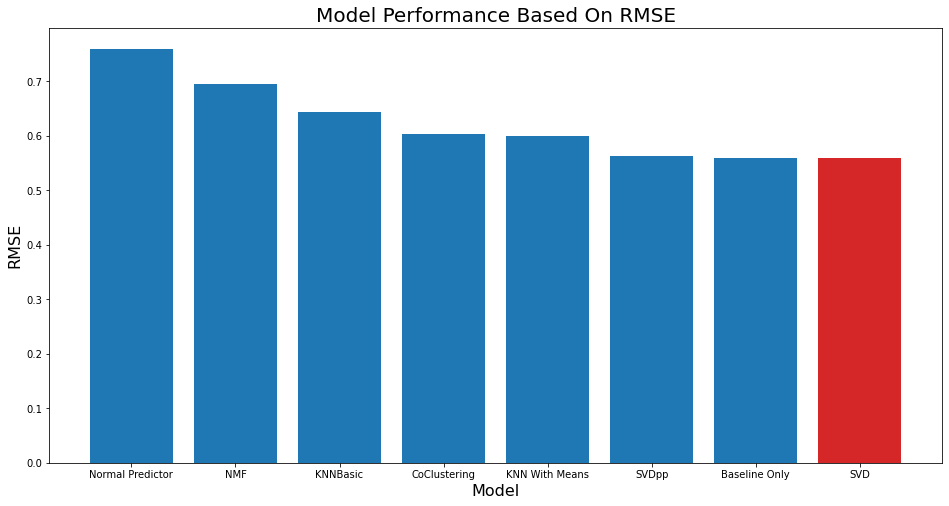

In [37]:
fig, ax = plt.subplots(figsize = (16,8))

plt.bar(model, scores,  align='center', label=model, color=["#1f77b4", "#1f77b4", "#1f77b4", "#1f77b4", "#1f77b4", "#1f77b4", "#1f77b4", "#d62728"])
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Model", fontsize=16),
plt.title("Model Performance Based On RMSE", fontsize=20)
plt.savefig("./Images/model_performance");

The SVD model had the lowest RMSE and thus is the most accurate model to predict ratings for our user data set. The SVD model will be used as the best_model in the recipe recommendation function.   